In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

<span style="color:red">**Please clone the repository or download the zip version from GitHub so that the Javascript map displays correctly on your computer!**</span>

## Choropleth Map
The goal of this homework is to build a [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) showing how much research funding goes to each Swiss canton. We use the [P3 database](http://p3.snf.ch/) from the Swiss National Science Foundation. Since the data only contain the names of universities, we need to map each university to a location – and more specifically a canton. To this end, we use the Google Places and Google Geocoding APIs. Finally the map is created in Javascript using the [Leaflet](http://leafletjs.com/) library.

### Importing the data
We get the data from the CSV file. In German, the text *Nicht zuteilbar - NA* means that there are no data so we specify we want the NaN value instead. We also specify that the index should be the *Project number* column. As seen below this index is unique.

In [2]:
df = pd.read_csv('P3_GrantExport.csv', sep=';', index_col=0, na_values=['Nicht zuteilbar - NA'])

In [3]:
df.index.is_unique

True

### Locations of universities
As seen below, the names of universities often contains a dash followed by the short name of the institute. To get more accurate results when using the Google API, we want to be able to remove this part of the name. The `trim_university_name(full_name)` function extracts only the first part of the university name.

We also define a `search_uni(university_name)` function which returns a tuple containing the canton the university is in, the latitude and the longitude. The canton name is represented with two letters (e.g. GE for Geneva). All of these functions are defined in the utils.py file.

In [4]:
from utils import trim_university_name, search_uni

For instance, we can get the location of EPFL. **Please keep in mind that you need a Google API key to use the `search_uni()` function.** The key has to be in a JSON file named `google_api_key.json`, associated with the `api_key` key.

In [5]:
#search_uni(trim_university_name('Ecole Polytechnique Fédérale de Lausanne - EPFL'))

We want to create a CSV file containing the list of all universities that receive funding with their associated location and canton. First we create a series containing the names of all universities.

In [6]:
uni_names = df.University.drop_duplicates().dropna()
uni_names.head()

﻿"Project Number"
4                   Université de Genève - GE
5     NPO (Biblioth., Museen, Verwalt.) - NPO
6                      Universität Basel - BS
8                 Université de Fribourg - FR
10                    Universität Zürich - ZH
Name: University, dtype: object

Our dataset contains 76 universities

In [7]:
uni_names.count()

76

Then, we want to associate each university to its location. We create a dictionary containing this mapping that we use to create a Pandas dataframe. **Executing this cell sends a lot of requests to the Google API, you may prefer to skip it and load the CSV in the next cell!**

In [8]:
#uni_infos = {uni: search_uni(trim_university_name(uni)) for uni in uni_names}
#uni_data = uni_names.map(lambda s: uni_infos[s] if uni_infos[s] is not None else (np.nan,) * 3)
#unis = pd.DataFrame(uni_data.tolist(), columns=['canton', 'latitude', 'longitude'], index=uni_names)
#unis.index.name = 'name'

Load the data from the CSV file (useful to avoid requesting all the data from Google if we already did it)

In [9]:
unis = pd.read_csv('universities.csv', index_col='name')
unis.head()

,canton,latitude,longitude
name,,,
Université de Genève - GE,GE,46.199444,6.145116
"NPO (Biblioth., Museen, Verwalt.) - NPO",NaN,NaN,NaN
Universität Basel - BS,BS,47.560253,7.582600
Université de Fribourg - FR,FR,46.806357,7.152006
Universität Zürich - ZH,ZH,47.374322,8.550981


Export the data to a CSV file.

In [10]:
unis.to_csv('universities.csv')

We can see that we miss the location of 16 universities. We'll add the data manually. Note that some entries do not correspond to a specific place. For instance *weitere Institute* means other institutes and the first row corresponds to several libraries and museums. We'll leave these entries empty to exclude them from the analysis since we can't associate them to a specific canton.

In [11]:
missing_loc = unis[unis.isnull().any(axis=1)]
print('There are {} entries without location data.'.format(len(missing_loc)))
missing_loc

There are 16 entries without location data.


,canton,latitude,longitude
name,,,
"NPO (Biblioth., Museen, Verwalt.) - NPO",NaN,NaN,NaN
"Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL",NaN,NaN,NaN
Weitere Institute - FINST,NaN,NaN,NaN
Firmen/Privatwirtschaft - FP,NaN,NaN,NaN
Eidg. Material und Prüfungsanstalt - EMPA,NaN,NaN,NaN
Physikal.-Meteorolog. Observatorium Davos - PMOD,NaN,NaN,NaN
Swiss Center for Electronics and Microtech. - CSEM,NaN,NaN,NaN
Weitere Spitäler - ASPIT,NaN,NaN,NaN
Forschungsanstalten Agroscope - AGS,NaN,NaN,NaN


In [12]:
additional_data = {
    'Physikal.-Meteorolog. Observatorium Davos - PMOD': ('GR', 46.8133161, 9.8422335),
    'Swiss Center for Electronics and Microtech. - CSEM': ('NE', 46.997778, 6.9453443),
    'Fachhochschule Nordwestschweiz (ohne PH) - FHNW': ('SO', 47.348146, 7.9056693),
    'Swiss Institute of Bioinformatics - SIB': ('VD', 46.5205653, 6.5721676),
    'Forschungskommission SAGW': ('BE', 46.94727, 7.4344473),
    'Pädag. Hochschule Tessin (Teilschule SUPSI) - ASP': ('TI', 46.02351, 8.9149293),
    'Schweizer Kompetenzzentrum Sozialwissensch. - FORS': ('VD', 46.5254827, 6.5784405),
    'Staatsunabh. Theologische Hochschule Basel - STHB': ('BS', 47.581238, 7.6479233)
}
new_df = pd.DataFrame.from_dict(additional_data, orient='index')
new_df.columns = ['canton', 'latitude', 'longitude']
unis.update(new_df) # Replace old data in the original dataframe

The 8 remaining entries could not be associated with a specific canton.

In [13]:
missing_loc = unis[unis.isnull().any(axis=1)]
len(missing_loc)

8

We can also notice that some universities aren't located in Switzerland (e.g. the Istituto Svizzero di Roma). And thus we can ignore them since they aren't associated with any canton. We also remove the NaN values at the same time since we already said we couldn't associate them to any canton.

In [14]:
swiss_cantons = ['ZH', 'BE', 'LU', 'UR', 'SZ', 'OW', 'NW', 'GL', 'ZG', 'FR', 'SO', 'BS', 'BL',
                 'SH', 'AR', 'AI', 'SG', 'GR', 'AG', 'TG', 'TI', 'VD', 'VS', 'NE', 'GE', 'JU']
unis = unis[unis.canton.isin(swiss_cantons)]

### Amount per canton
First, we create a new dataframe containing, for each project, the amount and the university. We need to convert the *amount* column to a numeric type since it's loaded from the CSV as a string.

In [15]:
amounts = df[['University', 'Approved Amount']]
amounts = amounts.rename(columns={'University': 'university', 'Approved Amount': 'amount'})
amounts.index.name = 'project'
amounts.amount = pd.to_numeric(amounts.amount, errors='coerce')
amounts.head()

,university,amount
project,,
1,NaN,11619.0
4,Université de Genève - GE,41022.0
5,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0
6,Universität Basel - BS,52627.0
7,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.0


We can now merge the two dataframes to also get the associated canton for each project. Finally, we can group by canton and sum to get the total amount of funding per canton.

In [16]:
amounts = amounts.merge(unis[['canton']], left_on='university', right_index=True, how='right')
amounts.head()

,university,amount,canton
project,,,
4,Université de Genève - GE,41022.0,GE
13,Université de Genève - GE,360000.0,GE
18,Université de Genève - GE,116991.0,GE
23,Université de Genève - GE,149485.0,GE
28,Université de Genève - GE,164602.0,GE


In [17]:
amounts = amounts.groupby('canton').sum()
amounts = amounts.amount # The dataframe has only one column so we extract it to get a Pandas series
amounts.head()

canton
AG    1.152690e+08
BE    1.555148e+09
BS    1.392498e+09
FR    4.590737e+08
GE    1.877102e+09
Name: amount, dtype: float64

The next cell makes sure all the Swiss cantons are in the `canton` series. We set the amount to 0 for the cantons that were missing.

In [18]:
amounts = amounts.reindex(pd.Series(swiss_cantons)).fillna(0)

### Building the map
We build directly the map in Javascript using the Leaflet library instead of using Folium – which is a Python wrapper around Leaflet. Our Javascript script is called `leaflet.js` and is located in the `js` folder.

We decided to use 6 classes to build our choropleth map since we noticed that using more than 6 makes it harder to spot the differences between non-ajdacent cantons. The map is interactive: you can hover a canton to show the absolute amount of funding, you can also choose whether to display the universities or not, it is also possible to show a line indicating the Röstigraben location. Moreover, we converted the TopoJSON file containing the Swiss cantons geometry to the GeoJSON format since Leaflet doesn't support the TopoJSON format. We chose the color for our 6 classes using [ColorBrewer](http://colorbrewer2.org).

To chose split our data in 6 classes, we created the `linear_split(nb_classes)` and `quantiles_split(nb_classes)` functions. The first one chooses the threshold such that each class represents the same amount of money. The second one use quantiles such that each class contains the same number of cantons (except for cantons with no funding).

In [19]:
def linear_split(nb_classes):
    linspace = np.linspace(amounts.min(), amounts.max(), nb_classes+1).round()
    # We don't want to include the min and max value in the scale so that it is compatible with our JS script
    return linspace[1:-1].tolist()

In [20]:
def quantiles_split(nb_classes):
    # We ignore zero values so that cantons with no funding don't have an impact on the scale
    return [round(amounts[amounts > 0].quantile(i/nb_classes)) for i in range(1, nb_classes)]

To make our data available to our JS script, we export it to a *data.js* file which we load in the HTML page.

In [21]:
def export_data(split_function):
    with open('js/data.js', 'w') as f:
        f.write('var universities = {}\n'.format(unis.reset_index().to_json(orient='records')))
        f.write('var cantons = {}\n'.format(amounts.to_json()))
        f.write('var scale = {}'.format(split_function(6)))

You can see the result below. **Please note that the map won't show in the preview made by GitHub. You should clone the repository and reevaluate all the cells.**

### Quantiles scale

In [22]:
from utils import display_map

In [23]:
export_data(quantiles_split)
display_map()

### Linear scale

When using a linear scale, the color difference is proportional to the approved amount difference. The problem is that the range of values is big, and when two cantons have close values, they have the same color. In fact, the difference threshold is so high that most cantons have the color corresponding to the smallest amount. A solution could have been to use a logarithmic scale, but it makes the reading of the map too difficult.

In [24]:
export_data(linear_split)
display_map()

### Bonus: Röstigraben
BONUS: using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in research funding between the areas divided by the Röstigraben?

We know that the following cantons are French speaking:
- Vaud (VD), Neuchatel (NE), Jura (JU), Geneva (GE)

In some cantons, both languages are spoken:
- Valais (VS), Fribourg (FR), Berne (BE)

In Valais (VS), only one university is in the German speaking part. On top of that, it has only received an amount of CHF 12'000.-, which corresponds to $0.04$% of the money received by the canton and to less than $0.00001$% of the total amount. Thus, we count Valais as a French speaking canton.

Fribourg (FR) is a complicated case, because the university is exactly on the Röstigraben. We cannot say if the people who received the money in Fribourg universities speak French or German, and thus we discard it.

For Berne (BE), this is easy: all universities are in the German speaking area, we thus count it as a German speaking canton.

Tessin is a particular case, because people speak neither French nor German (based on the Röstigraben map from Wikipedia). We decided to not take it into account, because the Röstigraben is only a border splitting the French and German speaking parts in two based on language, it has nothing to do with the Italian speaking part.

In [25]:
french_cantons = ['VD', 'NE', 'JU', 'VS', 'GE']
ignored_cantons = ['FR', 'TI']

Now, using the `amounts` table defined above, we can build the frame containing the amounts per canton for each region.

In [26]:
# The French speaking cantons
data_french = amounts[amounts.index.isin(french_cantons)].to_frame()
data_french['language'] = 'French speaking'
data_french.set_index('language', inplace=True)

# The German speaking cantons
data_german = amounts[~amounts.index.isin(french_cantons+ignored_cantons)].to_frame()
data_german['language'] = 'German speaking'
data_german.set_index('language', inplace=True)

Finally, the data are concatenated, groupbed by index and summed.

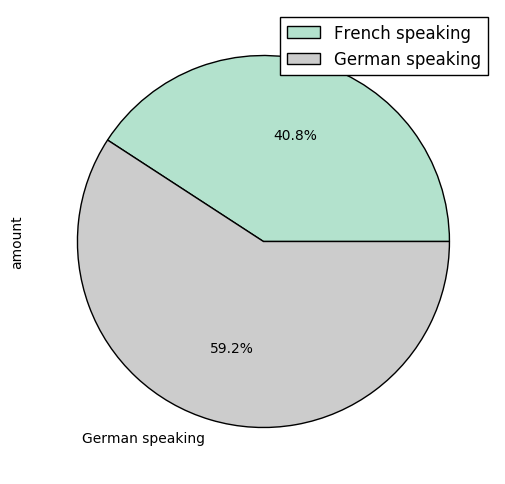

In [27]:
# Groupby index and sum the amounts per canton
rostigraben = pd.concat([data_french, data_german], axis=0)
grouped = rostigraben.groupby(rostigraben.index).sum()

# Plot
grouped.plot(y='amount', kind='pie', figsize=(6, 6), colormap='Pastel2', autopct='%1.1f%%')

From the above results, we can conclude that approximatelty 60% of the grants are given to the German speaking area institutions and approximately 40% of the funding goes to the French speaking area. We excluded Fribourg which receives also quite considerable amount of grants, but as it lies in the border of French and German speaking areas, we will not allocate the sum to either of the sides. For a rough estimate the German speaking area gets more funding than the French speaking.